In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import optuna
import tqdm
import joblib

import shap

pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
style.use('ggplot')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('D:/TMLC/Energy Intensity Prediction/Dataset/train.csv')
test = pd.read_csv('D:/TMLC/Energy Intensity Prediction/Dataset/test.csv')

In [3]:
df_train = train.copy()
df_test = test.copy()

In [4]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [5]:
train

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,48,30,41.637931,58,29,41.338710,62,34,50.183333,79,40,52.145161,79,41,56.233333,86,48,58.758065,81,48,61.612903,87,41,53.783333,73,37,47.661290,59,34,44.650000,62,15,30.338710,46,55,6218,106.32,36.6,438,47.911202,26,2,0,0,6,0,0,0,NaN,NaN

In [6]:
test

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,Residential,5plus_Unit_Building,305925.0,2013.0,99.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85457
9701,7,State_11,Residential,5plus_Unit_Building,34909.0,1910.0,94.0,26.5,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85458
9702,7,State_11,Residential,5plus_Unit_Building,42393.0,2014.0,94.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85459
9703,7,State_11,Residential,5pl

# EXPLORATORY DATA ANALYSIS

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [8]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9613 non-null   float64
 6   energy_star_rating         7451 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

In [10]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [11]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.500000
direction_peak_wind_speed,41811,55.200000
direction_max_wind_speed,41082,54.200000
max_wind_speed,41082,54.200000
energy_star_rating,26709,35.300000
year_built,1837,2.400000


In [12]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,9117,93.900000
direction_max_wind_speed,8575,88.400000
direction_peak_wind_speed,8575,88.400000
max_wind_speed,8575,88.400000
energy_star_rating,2254,23.200000
year_built,92,0.900000


In [13]:
test['site_eui'] = np.nan
test['dataset'] = 'test'
train['dataset'] = 'train'


df_all = pd.concat([train, test], axis=0, ignore_index=True)

In [14]:
df_all.head(40)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,train
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,train
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,train
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,train
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,train
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5,train
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,56.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,6,train
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,99.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,7,train
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,98.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,28.199578,8,train
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,83.0,2.4,36,50.5,68

In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85462 entries, 0 to 85461
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                85462 non-null  int64  
 1   State_Factor               85462 non-null  object 
 2   building_class             85462 non-null  object 
 3   facility_type              85462 non-null  object 
 4   floor_area                 85462 non-null  float64
 5   year_built                 83533 non-null  float64
 6   energy_star_rating         56499 non-null  float64
 7   ELEVATION                  85462 non-null  float64
 8   january_min_temp           85462 non-null  int64  
 9   january_avg_temp           85462 non-null  float64
 10  january_max_temp           85462 non-null  int64  
 11  february_min_temp          85462 non-null  int64  
 12  february_avg_temp          85462 non-null  float64
 13  february_max_temp          85462 non-null  int

In [16]:
df_all['energy_star_rating'].value_counts()

100.0    2198
1.0      1097
89.0      927
84.0      924
85.0      912
         ... 
16.0      284
11.0      284
12.0      282
10.0      272
0.0         1
Name: energy_star_rating, Length: 101, dtype: int64

In [17]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85462 entries, 0 to 85461
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                85462 non-null  int64  
 1   State_Factor               85462 non-null  object 
 2   building_class             85462 non-null  object 
 3   facility_type              85462 non-null  object 
 4   floor_area                 85462 non-null  float64
 5   year_built                 83533 non-null  float64
 6   energy_star_rating         56499 non-null  float64
 7   ELEVATION                  85462 non-null  float64
 8   january_min_temp           85462 non-null  int64  
 9   january_avg_temp           85462 non-null  float64
 10  january_max_temp           85462 non-null  int64  
 11  february_min_temp          85462 non-null  int64  
 12  february_avg_temp          85462 non-null  float64
 13  february_max_temp          85462 non-null  int

In [18]:
df_all.isnull().sum()

Year_Factor           0
State_Factor          0
building_class        0
facility_type         0
floor_area            0
                  ...  
max_wind_speed    49657
days_with_fog     54913
site_eui           9705
id                    0
dataset               0
Length: 65, dtype: int64

In [19]:
df_all['year_built'].fillna(df_all['year_built'].median(), inplace = True)

In [20]:
df_all['energy_star_rating'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [21]:
df_all['direction_max_wind_speed'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [22]:
df_all['direction_peak_wind_speed'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [23]:
df_all['max_wind_speed'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [24]:
df_all['days_with_fog'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [25]:
df_all['site_eui'].fillna(df_all['site_eui'].median(), inplace = True)

In [26]:
df_all.isnull().sum()

Year_Factor       0
State_Factor      0
building_class    0
facility_type     0
floor_area        0
                 ..
max_wind_speed    0
days_with_fog     0
site_eui          0
id                0
dataset           0
Length: 65, dtype: int64

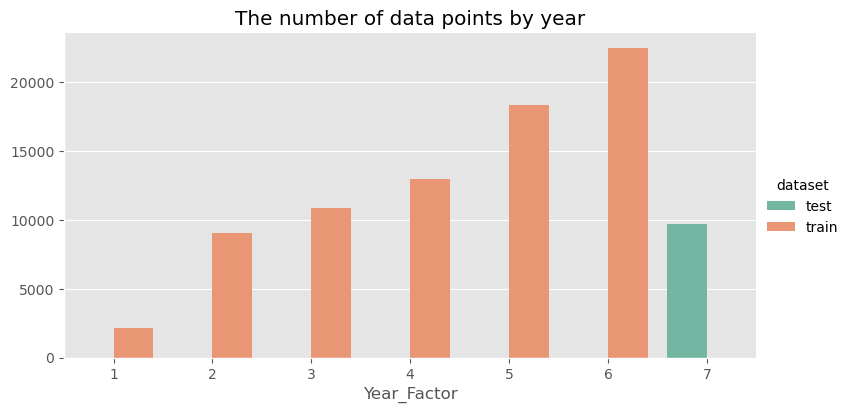

In [27]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

In [28]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

Text(0.5, 0, '')

In [29]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');

In [31]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

In [32]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui',hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

In [33]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

# Data Preprocessing

In [34]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [35]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

In [36]:
target='site_eui'
cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all[col] = encoder.fit_transform(df_all[col], df_all[target])

In [37]:
df_all

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,3,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,43,61.000000,84,36,55.116667,77,24,45.387097,68,826,2542,4.50,0.0,0,60.056164,20,0,0,0,111,31,5,0,68.0,68.0,68.0,68.0,6.800000,1456,train
1,4,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,55,68.661290,95,46,59.650000,76,41,56.790323,68,497,1477,20.69,0.0,0,62.067123,0,0,0,0,27,6,0,0,68.0,68.0,68.0,68.0,8.200000,2673,train
2,5,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,49,69.580645,96,29,52.866667,75,28,48.580645,68,1319,1823,7.95,0.0,0,63.398630,4,0,0,0,136,52,10,0,68.0,68.0,68.0,68.0,12.300000,3769,train
3,7,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,68.0,68.0,68.0,68.0,75.293716,76077,test
4,3,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,35,56.967742,85,31,52.516667,76,16,43.338710,68,303,3108,4.16,0.0,0,57.082192,33,2,0,0,72,10,0,0,68.0,68.0,68.0,68.0,63.083288,2144,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,84.223780,79.815538,83.425312,900000.0,1960.0,90.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,33,58.129032,83,17,41.583333,74,3,29.933333,57,866,5264,43.54,27.3,51,52.646006,97,45,13,0,77,5,0,0,68.0,68.0,68.0,68.0,75.293716,79514,test
85458,6,84.223780,79.815538,83.425312,1179072.0,1959.0,96.0,3.0,8,29.827586,62,4,33.896552,62,24,45.967742,79,18,49.931034,81,37,59.161290,89,45,70.465517,90,57,77.083333,96,54,75.725806,95,40,68.200000,96,24,55.258065,85,20,44.316667,71,12,35.129032,58,1114,5074,35.78,13.9,18,53.839335,97,29,6,0,101,21,0,0,1.0,1.0,1.0,116.0,43.533097,68730,train
85459,7,84.223780,79.815538,83.425312,1179072.0,1959.0,92.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,33,58.129032,83,17,41.583333,74,3,29.933333,57,866,5264,43.54,27.3,51,52.646006,97,45,13,0,77,5,0,0,68.0,68.

# Feature Engineering

In [38]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all.columns if 'temp' in col]

df_all['min_temp'] = df_all[temp].min(axis=1)
df_all['max_temp'] = df_all[temp].max(axis=1)
df_all['avg_temp'] = df_all[temp].mean(axis=1)
df_all['std_temp'] = df_all[temp].std(axis=1)
df_all['skew_temp'] = df_all[temp].skew(axis=1)

# by seasons
temp = pd.Series([col for col in df_all.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all['min_winter_temp'] = df_all[winter_temp].min(axis=1)
df_all['max_winter_temp'] = df_all[winter_temp].max(axis=1)
df_all['avg_winter_temp'] = df_all[winter_temp].mean(axis=1)
df_all['std_winter_temp'] = df_all[winter_temp].std(axis=1)
df_all['skew_winter_temp'] = df_all[winter_temp].skew(axis=1)
### spring
df_all['min_spring_temp'] = df_all[spring_temp].min(axis=1)
df_all['max_spring_temp'] = df_all[spring_temp].max(axis=1)
df_all['avg_spring_temp'] = df_all[spring_temp].mean(axis=1)
df_all['std_spring_temp'] = df_all[spring_temp].std(axis=1)
df_all['skew_spring_temp'] = df_all[spring_temp].skew(axis=1)
### summer
df_all['min_summer_temp'] = df_all[summer_temp].min(axis=1)
df_all['max_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['avg_summer_temp'] = df_all[summer_temp].mean(axis=1)
df_all['std_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['skew_summer_temp'] = df_all[summer_temp].max(axis=1)
## autumn
df_all['min_autumn_temp'] = df_all[autumn_temp].min(axis=1)
df_all['max_autumn_temp'] = df_all[autumn_temp].max(axis=1)
df_all['avg_autumn_temp'] = df_all[autumn_temp].mean(axis=1)
df_all['std_autumn_temp'] = df_all[autumn_temp].std(axis=1)
df_all['skew_autumn_temp'] = df_all[autumn_temp].skew(axis=1)

In [39]:
df_all['month_cooling_degree_days'] = df_all['cooling_degree_days']/12
df_all['month_heating_degree_days'] = df_all['heating_degree_days']/12

In [40]:
# total area
df_all['building_area'] = df_all['floor_area'] * df_all['ELEVATION']
# rating energy by floor
df_all['floor_energy_star_rating'] = df_all['energy_star_rating']/df_all['ELEVATION']

# Checking target variable transformation

In [41]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

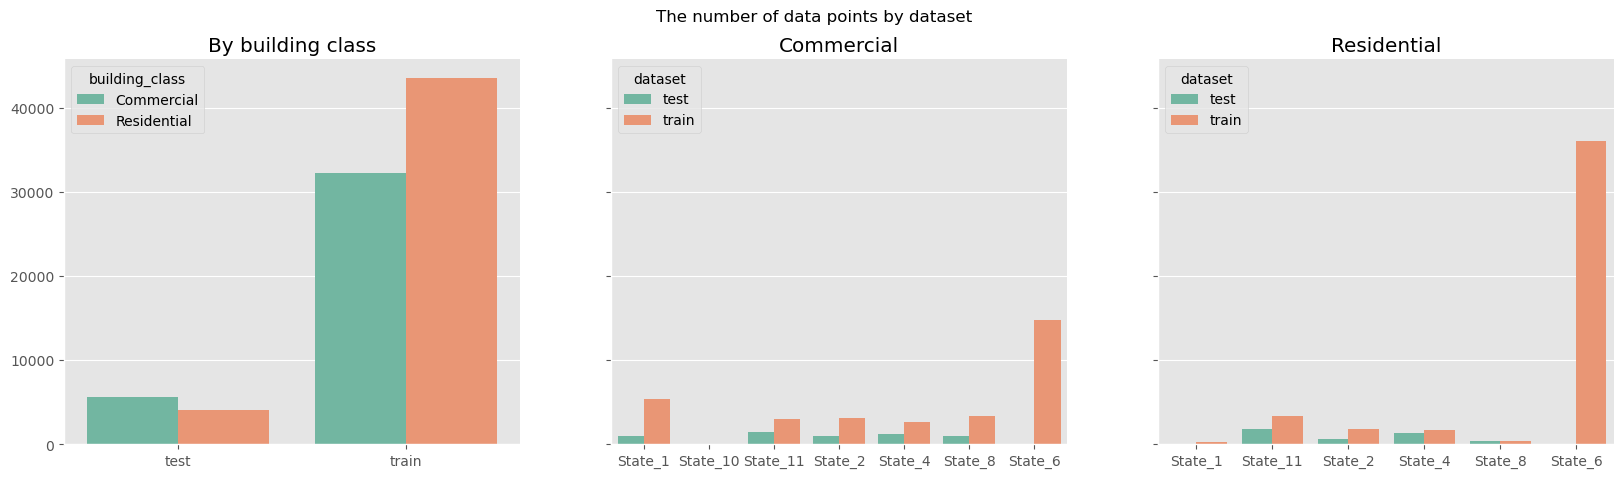

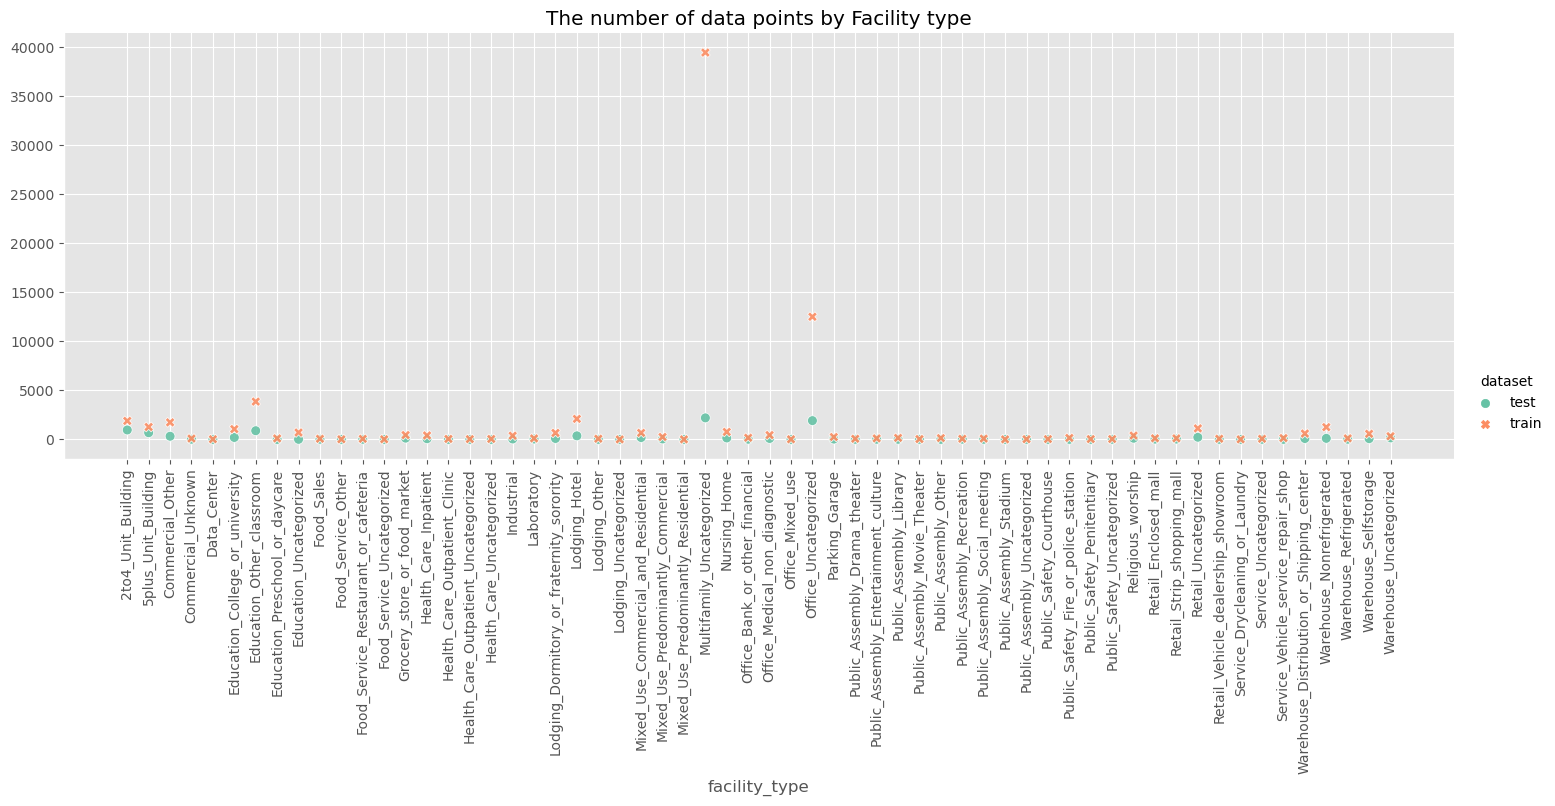

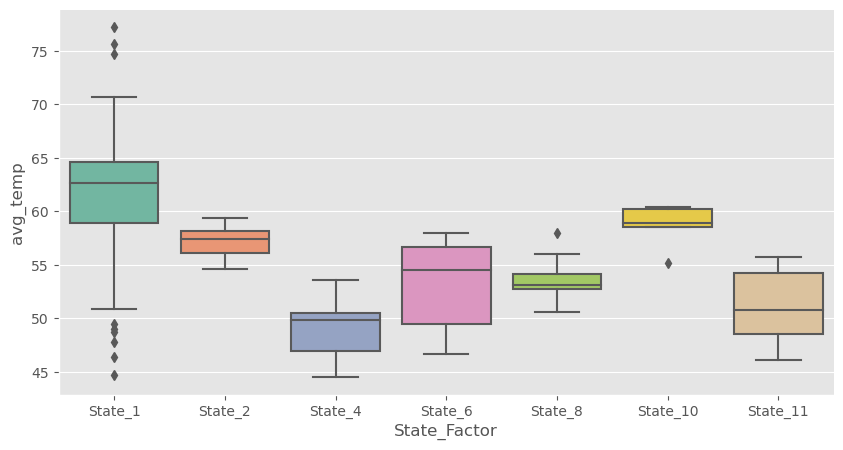

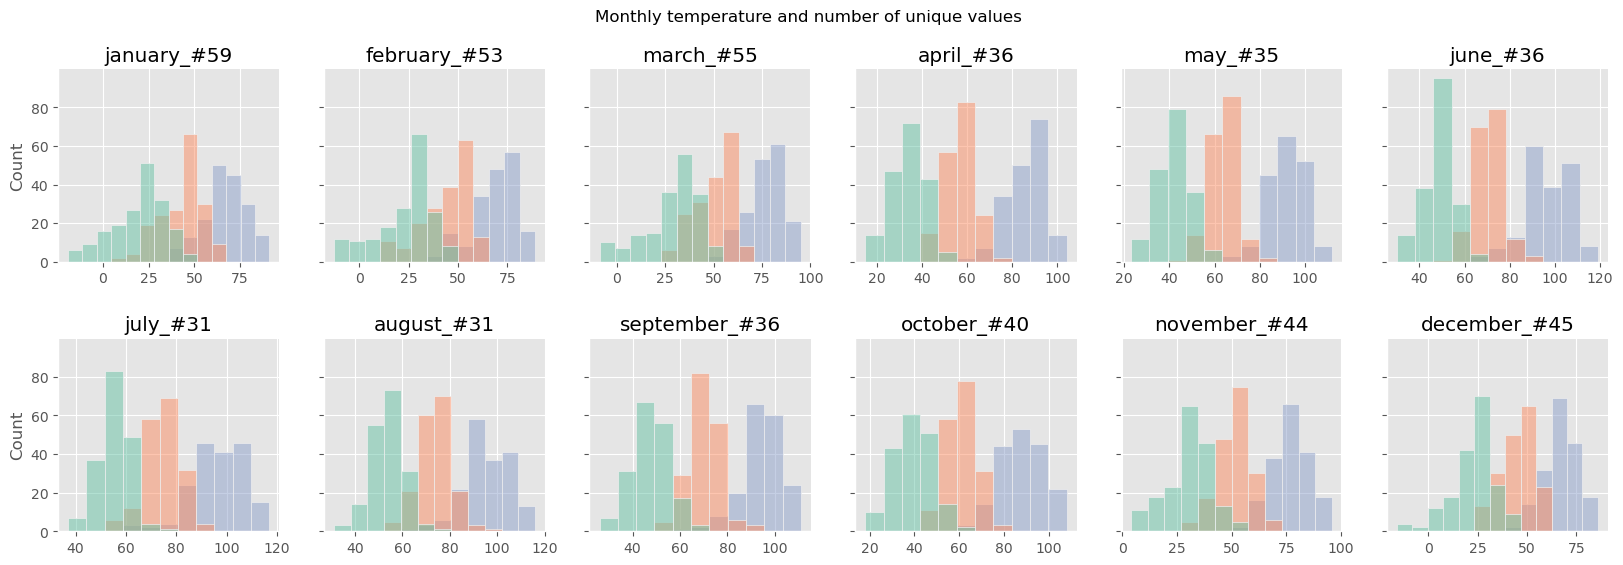

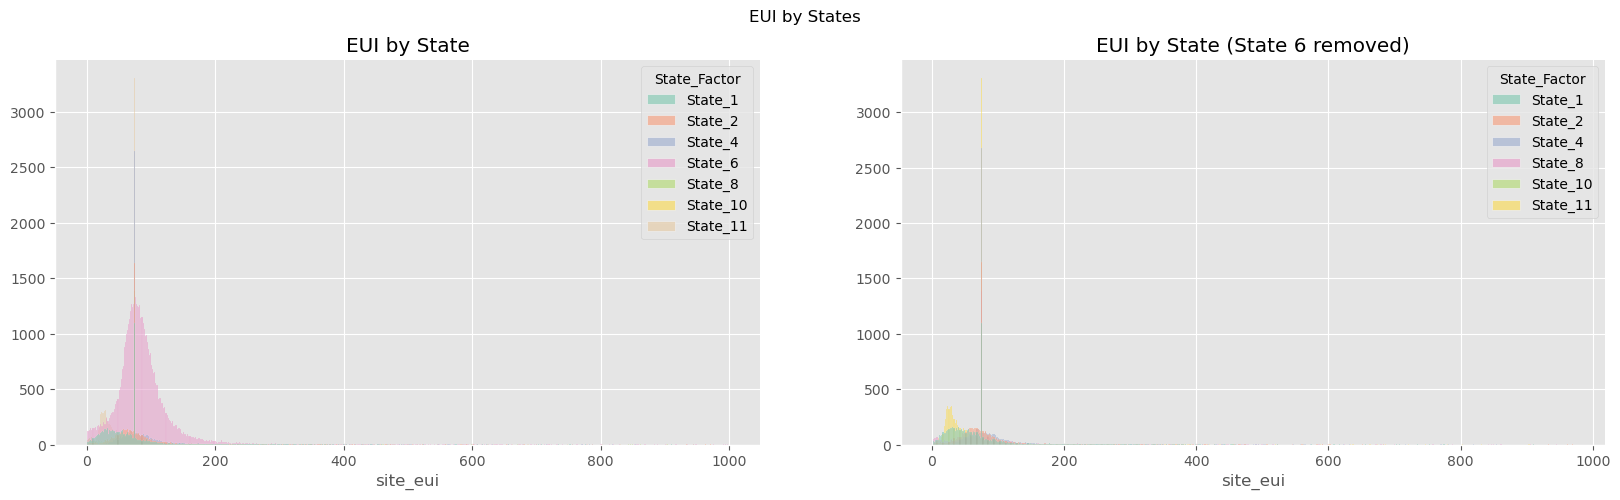

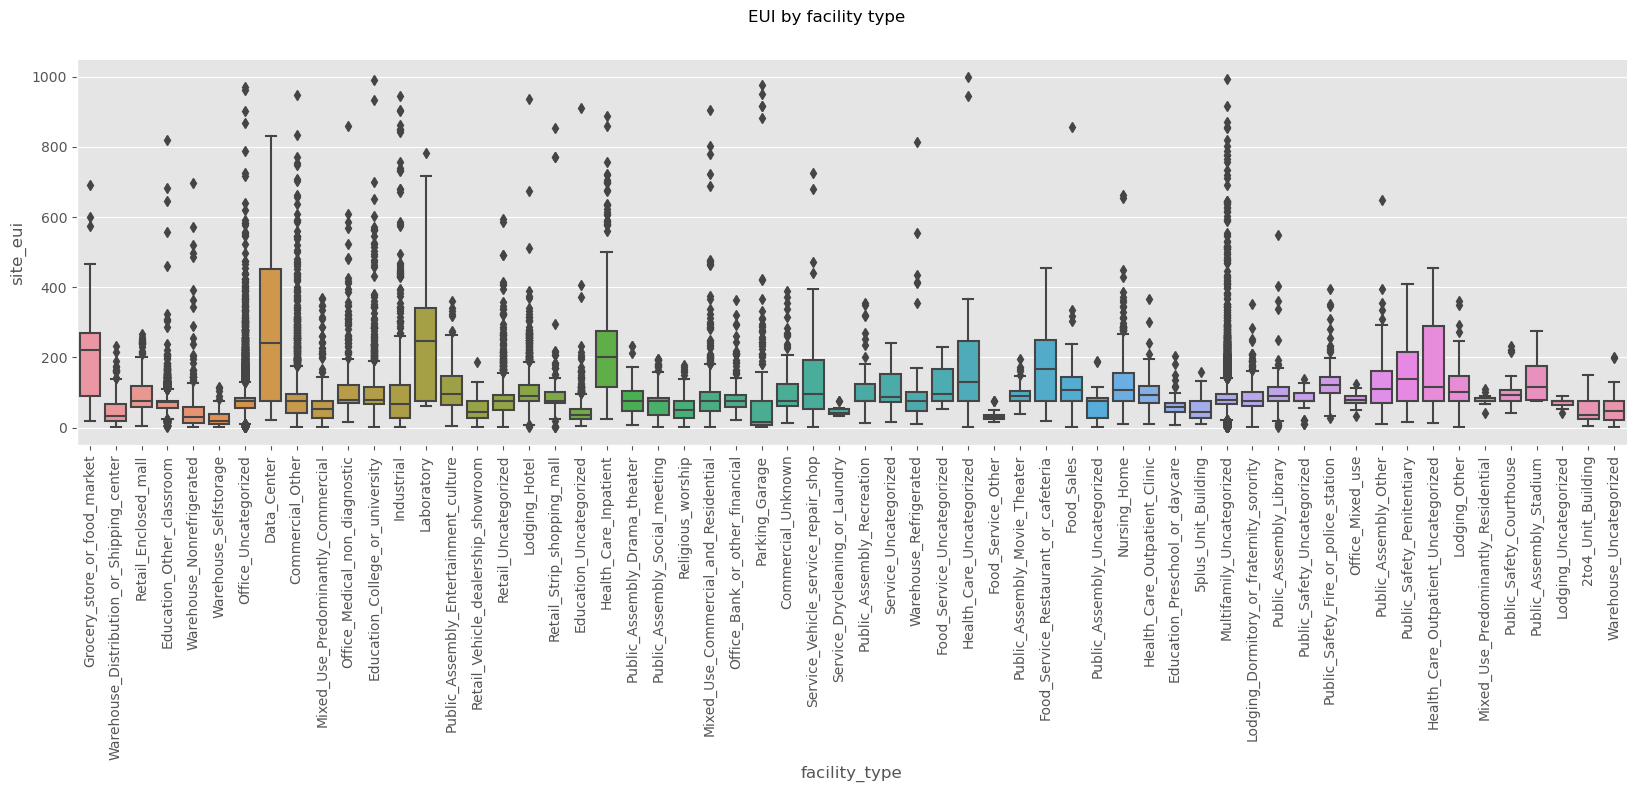

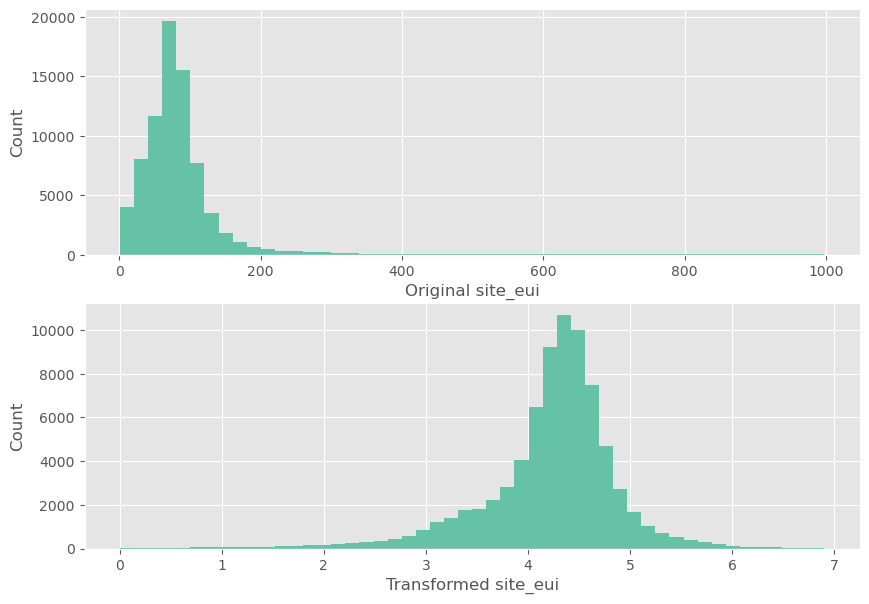

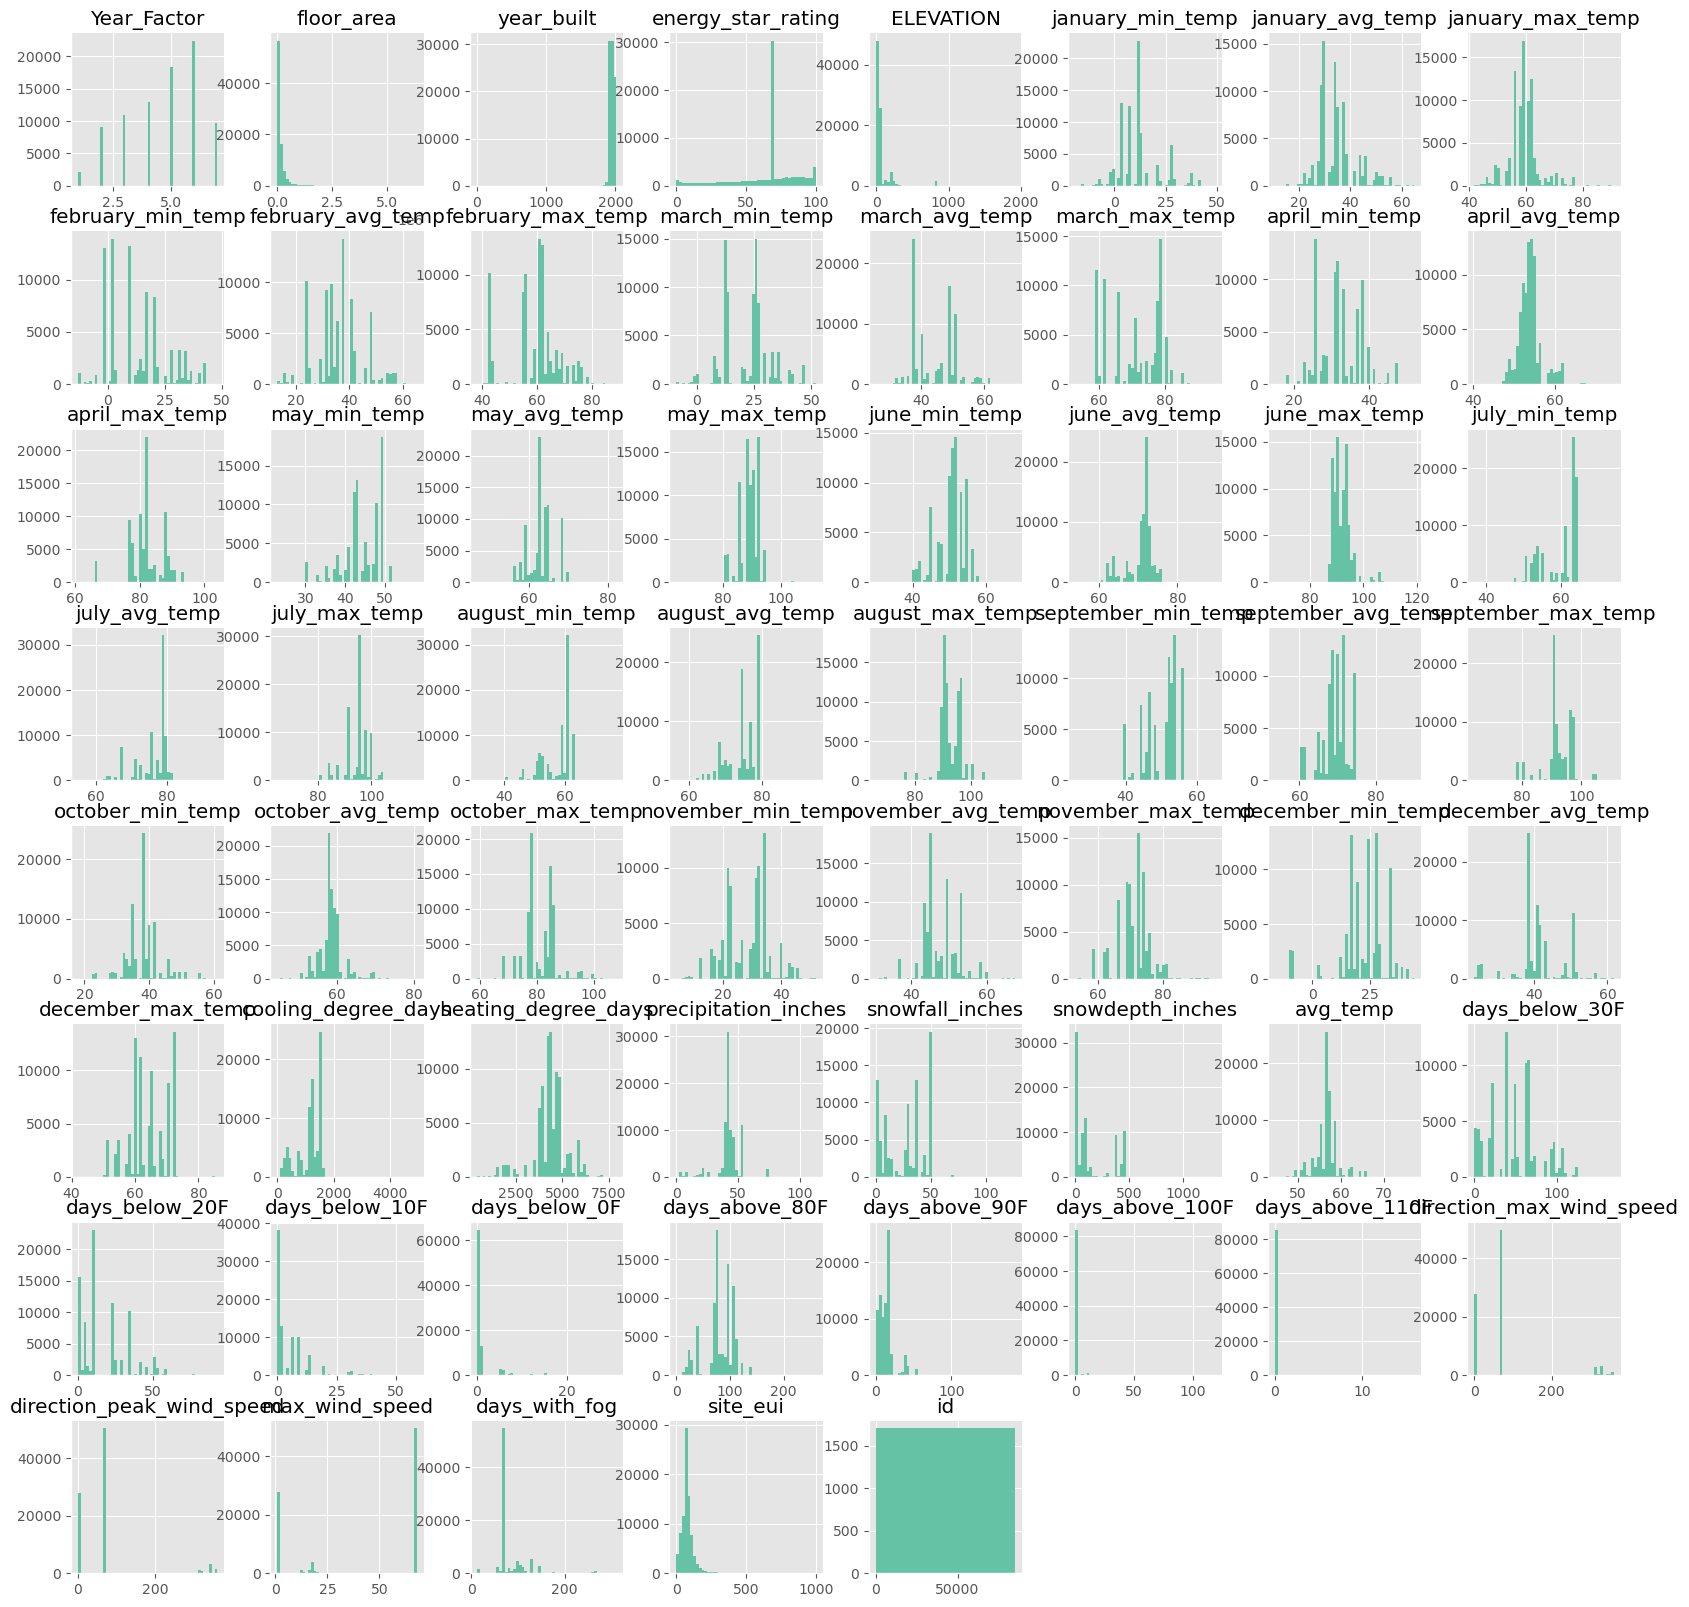

In [42]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [43]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.842043
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

In [44]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all[var] = np.where(df_all[var]==0, 0, 1)

In [45]:
df_all.shape

(85462, 93)

In [46]:
df_all.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,...,68.0,68.0,68.0,68.0,6.800000,1456,train,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,1.487965
1,4,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,...,68.0,68.0,68.0,68.0,8.200000,2673,train,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.564784
2,5,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,...,68.0,68.0,68.0,68.0,12.300000,3769,train,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,1.150592
3,7,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,...,68.0,68.0,68.0,68.0,75.293716,76077,test,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.150592
4,3,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,...,68.0,68.0,68.0,68.0,63.083288,2144,train,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,7.472527


In [47]:
cats = ['State_Factor', 'facility_type', 'building_class']

# typecasting numerical features
for col in df_all.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    df_all[col] = df_all[col].astype('float64')

In [48]:
df_all.drop(columns=cats)

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,68.0,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,...,68.0,68.0,68.0,68.0,6.800000,1456,train,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,1.487965
1,4.0,10149.0,1931.0,68.0,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,68.0,68.0,68.0,68.0,8.200000,2673,train,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.564784
2,5.0,10149.0,1931.0,68.0,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,...,68.0,68.0,68.0,68.0,12.300000,3769,train,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,1.150592
3,7.0,10149.0,1931.0,68.0,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,...,68.0,68.0,68.0,68.0,75.293716,76077,test,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.150592
4,3.0,10755.0,1937.0,68.0,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,...,68.0,68.0,68.0,68.0,63.083288,2144,train,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,7.472527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7.0,900000.0,1960.0,90.0,130.8,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,54.800000,85.0,38.0,59.096774,92.0,40.0,68.6

In [49]:
df_all.head(15)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,...,68.0,68.0,68.0,68.0,6.800000,1456,train,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,1.487965
1,4.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,...,68.0,68.0,68.0,68.0,8.200000,2673,train,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.564784
2,5.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,...,68.0,68.0,68.0,68.0,12.300000,3769,train,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,1.150592
3,7.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,68.0,68.0,68.0,68.0,75.293716,76077,test,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.150592
4,3.0,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,...,68.0,68.0,68.0,68.0,63.083288,2144,train,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,7.472527
5,4.0,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,...,68.0,68.0,68.0,68.0,56.992329,3400,train,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141

In [50]:
train = df_all[df_all['dataset']=='train']
test = df_all[df_all['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui']

train = train.drop(['id', 'dataset', 'site_eui'], axis=1)
test = test.drop(['id', 'dataset', 'site_eui'], axis=1)

In [51]:
train.head(20)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,...,31.0,1.0,0.0,68.0,68.0,68.0,68.0,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,1.487965
1,4.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,...,6.0,0.0,0.0,68.0,68.0,68.0,68.0,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.564784
2,5.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,...,52.0,1.0,0.0,68.0,68.0,68.0,68.0,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,1.150592
3,3.0,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,...,10.0,0.0,0.0,68.0,68.0,68.0,68.0,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,7.472527
4,4.0,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,...,6.0,0.0,0.0,68.0,68.0,68.0,68.0,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,97870.5,7.472527
5,5.0,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,...,52.0,1.0,0.0,68.0,68.0,68.0,68.0,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,

In [52]:
test

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,7.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.150592
1,7.0,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,18.6,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,200043.0,3.655914
2,7.0,64.220446,84.203693,89.916951,11730.0,1937.0,68.0,2.4,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,28152.0,28.333333
3,7.0,64.220446,84.203693,89.916951,13000.0,1946.0,68.0,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,768300.0,1.150592
4,7.0,64.220446,84.203693,89.916951,13200.0,1907.0,68.0,43.9,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,579480.0,1.548975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7.0,84.223780,79.815538,83.425312,852000.0,2009.0,59.0,130.8,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,54.80,85.0,3

In [55]:
y_test = pd.read_csv('D:/TMLC/Energy Intensity Prediction/Dataset/Y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 90)
Test: (9705, 90)
Samples:  (75757,)
Targets:  (9705,)


In [56]:
y_test

0       166.588554
1       259.381565
2       158.537090
3       261.441520
4       242.967711
           ...    
9700     23.677329
9701     20.512284
9702     39.285975
9703     29.529438
9704     15.492899
Name: site_eui, Length: 9705, dtype: float64

In [57]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 90 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  float64
 1   State_Factor               75757 non-null  float64
 2   building_class             75757 non-null  float64
 3   facility_type              75757 non-null  float64
 4   floor_area                 75757 non-null  float64
 5   year_built                 75757 non-null  float64
 6   energy_star_rating         75757 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  float64
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  float64
 11  february_min_temp          75757 non-null  float64
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  flo

# Feature selection

In [58]:
from sklearn.feature_selection import mutual_info_regression
# determine the mutual information
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info

array([0.19948078, 0.1523144 , 0.03769409, 0.23840723, 0.10170157,
       0.06607656, 0.24422744, 0.16322785, 0.24543584, 0.37980487,
       0.31063079, 0.37342766, 0.37785366, 0.33383523, 0.34487489,
       0.37805101, 0.34516374, 0.35864107, 0.37918224, 0.24267139,
       0.35032628, 0.26546192, 0.29899517, 0.3273724 , 0.377615  ,
       0.32431193, 0.19991161, 0.37545767, 0.14965256, 0.2050592 ,
       0.37876033, 0.33412329, 0.33695805, 0.37549817, 0.28759253,
       0.28669051, 0.36361696, 0.32667465, 0.36501207, 0.38070208,
       0.32536762, 0.33625909, 0.38001951, 0.36244012, 0.37779386,
       0.37807159, 0.37628534, 0.37357888, 0.37637874, 0.37821525,
       0.37838724, 0.23964723, 0.29863432, 0.27316969, 0.3786625 ,
       0.28818429, 0.01002917, 0.00087162, 0.03000483, 0.03003324,
       0.02763462, 0.10975968, 0.36790418, 0.27188477, 0.37756233,
       0.37842773, 0.36906139, 0.34937284, 0.37965832, 0.37835583,
       0.37424007, 0.34329354, 0.31232154, 0.37854826, 0.37868

In [59]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

november_avg_temp            0.380702
avg_autumn_temp              0.380331
december_avg_temp            0.380020
january_avg_temp             0.379805
avg_winter_temp              0.379658
                               ...   
direction_peak_wind_speed    0.030033
direction_max_wind_speed     0.030005
max_wind_speed               0.027635
days_above_100F              0.010029
days_above_110F              0.000872
Length: 90, dtype: float64

In [60]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

<AxesSubplot:>

In [61]:
from sklearn.feature_selection import SelectKBest

In [62]:
#No we Will select the  top 5 important features
sel_five_cols = SelectKBest(mutual_info_regression, k=5)
sel_five_cols.fit(X_train, y_train)
X_train.columns[sel_five_cols.get_support()]

Index(['january_avg_temp', 'december_avg_temp', 'avg_winter_temp',
       'avg_autumn_temp', 'month_heating_degree_days'],
      dtype='object')

In [63]:
X_train.shape

(75757, 90)

In [64]:
X_train_new = sel_five_cols.transform(X_train)
X_test_new =  sel_five_cols.transform(X_test)

In [65]:
X_train_new.shape

(75757, 5)

# XGBoost

In [66]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train_new, y_train)
y_pred = xgb.predict(X_test_new)

In [67]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 61.28862731543615
 MAE: 34.97309684483098
 MSE: 3756.2958382104266
 R2: -0.03889127991199204


# Random Forest

In [68]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train_new, y_train)
y_pred = rf.predict(X_test_new)

In [69]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 61.41361962253818
 MAE: 37.03502687914101
 MSE: 3771.6326751418064
 R2: -0.043133040102274034


In [70]:
model =  RandomForestRegressor()

In [71]:
model.fit(X_train_new, y_train)

RandomForestRegressor()

In [72]:
y_pred =model.predict(X_test_new)

In [73]:
y_pred

array([41.23612533, 41.23612533, 41.23612533, ..., 71.18707955,
       71.18707955, 71.18707955])

# Final Evaluation (Random Forest)

In [74]:
y_hat_tuned = model.predict(X_test_new)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

Text(0.5, 0, 'iteration')

# Saving Models

In [75]:
import pickle 
pickle_out = open("model.pkl", mode = "wb") 
pickle.dump(model, pickle_out) 
pickle_out.close()

# Explainable AI

In [76]:
shap.initjs()

In [77]:
X_sample =pd.DataFrame( X_train_new,columns = X_train.columns[sel_five_cols.get_support()]).sample(2000)

In [78]:
X_sample

,january_avg_temp,december_avg_temp,avg_winter_temp,avg_autumn_temp,month_heating_degree_days
17945,21.403226,39.177419,24.729125,54.660155,505.833333
32909,34.451613,38.338710,35.277469,61.591637,354.333333
48558,29.854839,50.774194,35.508385,61.920191,371.666667
60296,29.854839,50.774194,35.508385,61.920191,371.666667
59595,37.322581,41.467742,40.741070,58.635006,331.500000
...,...,...,...,...,...
61935,29.854839,50.774194,35.508385,61.920191,371.666667
69253,37.322581,41.467742,40.741070,58.635006,331.500000
25904,29.854839,50.774194,35.508385,61.920191,371.666667
56128,37.322581,41.467742,40.741070,58.635006,331.500000


In [79]:
shap_values = shap.TreeExplainer(rf).shap_values(X_sample)

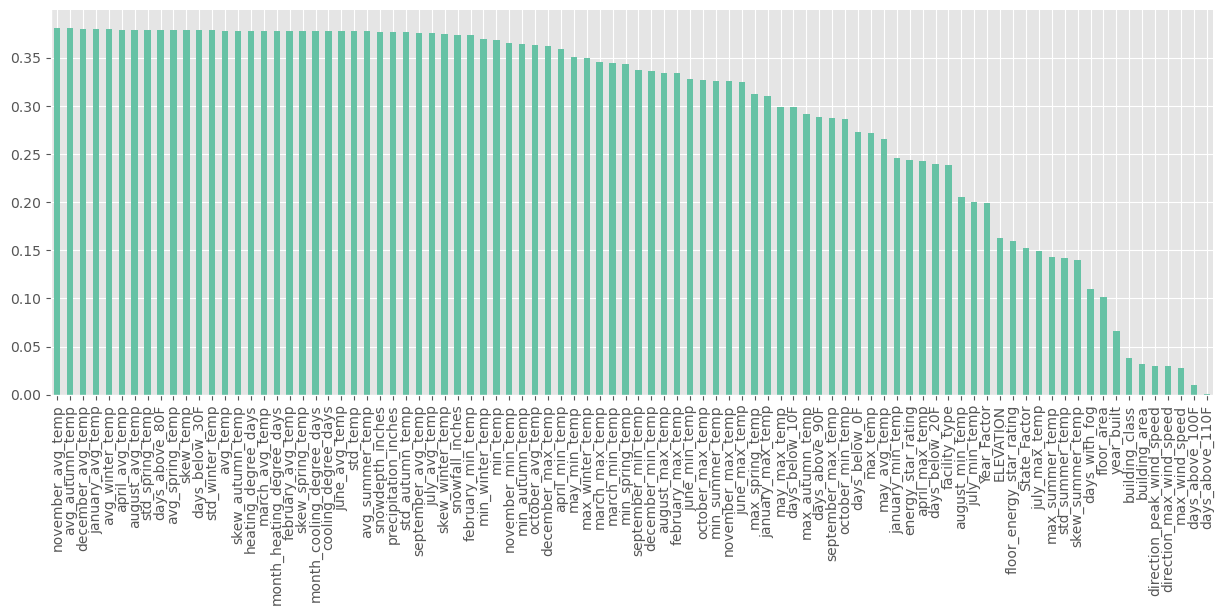

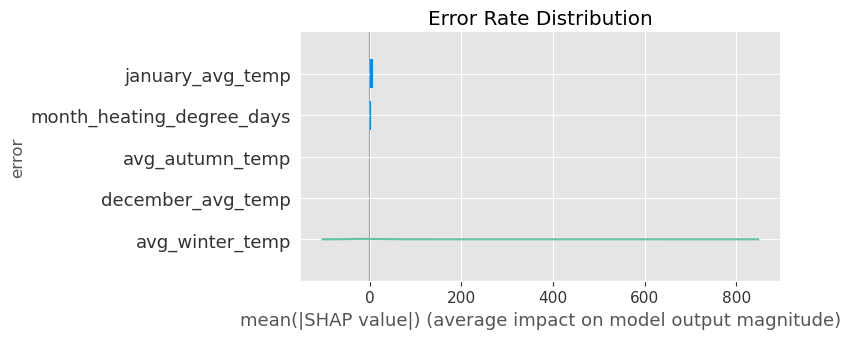

In [80]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

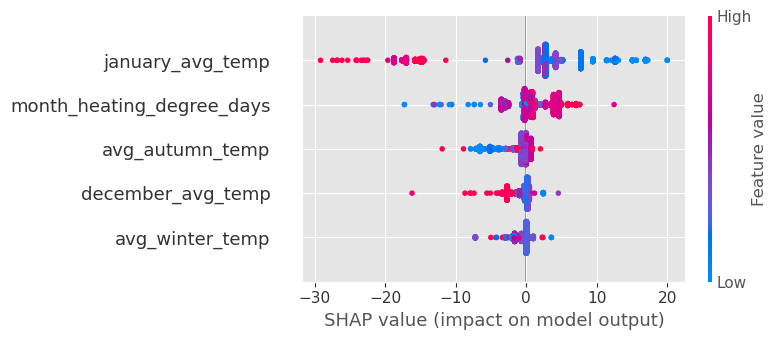

In [81]:
shap.summary_plot(shap_values, X_sample)

In [82]:
limit = 200
shap.force_plot(shap.TreeExplainer(model).expected_value[0], shap_values[0:limit,:], X_sample.iloc[0:limit,:])

In [83]:
row = 60
print(y_pred[row])
shap.initjs()
shap.force_plot(shap.TreeExplainer(model).expected_value[0], shap_values[row], X_sample.iloc[row])

41.23612533090379


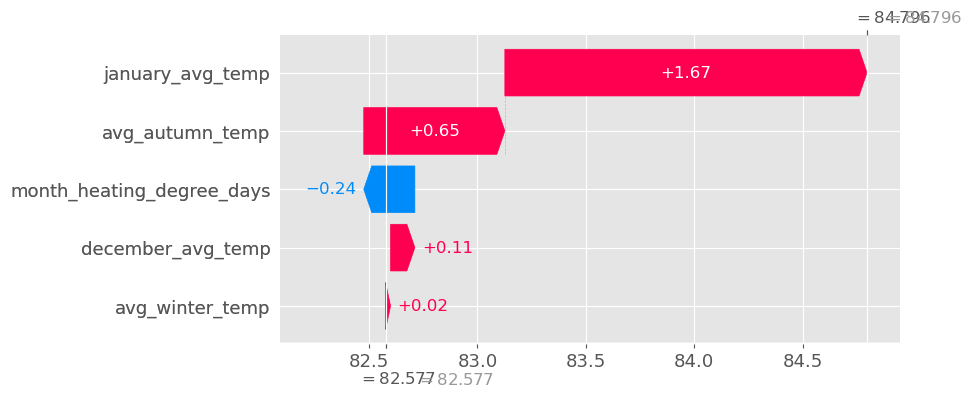

In [84]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=X_sample.columns.tolist()
                                      )

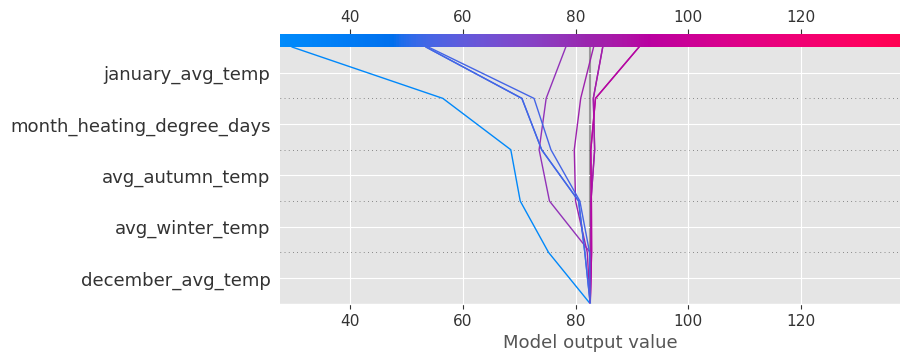

In [85]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=X_sample.columns.tolist())